# Predict ECG 's Signal Class among 5 Categories

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate,\
Dense,Dropout,LSTM,Masking,Bidirectional,Dropout,GRU,SimpleRNN,TimeDistributed
from keras.models import Sequential,Model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import collections


%matplotlib inline
path='/gdrive/My Drive/Colab Notebooks/ML4HC/project3/'

## Import Dataset

In [0]:
df_train = pd.read_csv(path+"Data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv(path+"Data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

## Data Statistics and ECG Visualization

In [0]:
frequencies=collections.Counter(Y)
for label,frequency in sorted(frequencies.items()):
  print("Class %i contains %i items and consists of %0.2f%s of the data"%(label,frequency,frequency/len(Y)*100,'%'))

Class 0 contains 72471 items and consists of 82.77% of the data
Class 1 contains 2223 items and consists of 2.54% of the data
Class 2 contains 5788 items and consists of 6.61% of the data
Class 3 contains 641 items and consists of 0.73% of the data
Class 4 contains 6431 items and consists of 7.35% of the data


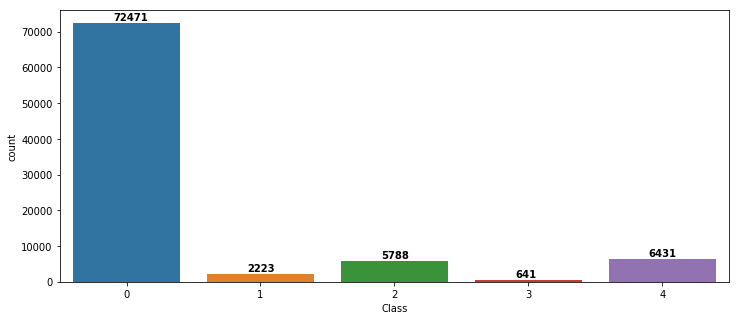

In [0]:
plt.figure(figsize=(12,5))
ax=sns.countplot(Y)
ax.set_xlabel("Class")
for line in range(5):
     ax.text(line-0.1, frequencies[line]+700,s=str(frequencies[line]), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

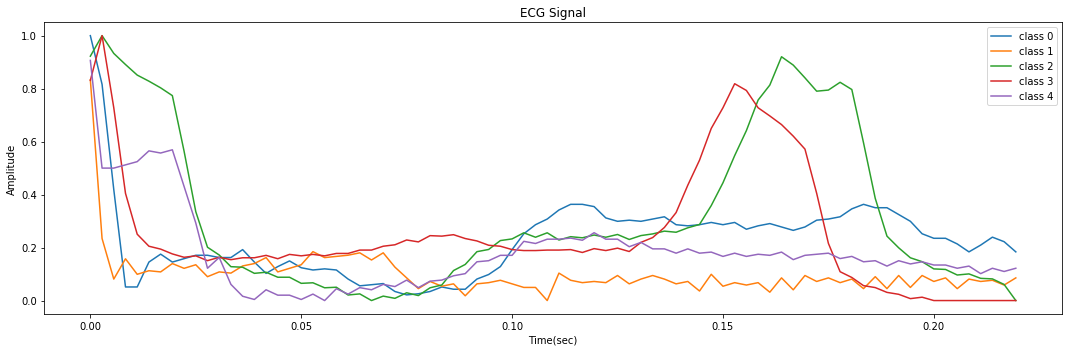

In [7]:
class1,class2,class3,class4,class5=np.where(Y==0)[0],np.where(Y==1)[0],np.where(Y==2)[0],np.where(Y==3)[0],np.where(Y==4)[0]
x=np.arange(187)/360
plt.figure(figsize=(15,5))
plt.plot(x[:80],X[class1[0]][:80].ravel(),label='class 0')
plt.plot(x[:80],X[class2[0]][:80].ravel(),label='class 1')
plt.plot(x[:80],X[class3[0]][:80].ravel(),label='class 2')
plt.plot(x[:80],X[class4[0]][:80].ravel(),label='class 3')
plt.plot(x[:80],X[class5[0]][:80].ravel(),label='class 4')
plt.legend()
plt.xlabel('Time(sec)')
plt.ylabel("Amplitude")
plt.title("ECG Signal")
plt.tight_layout()
plt.show()


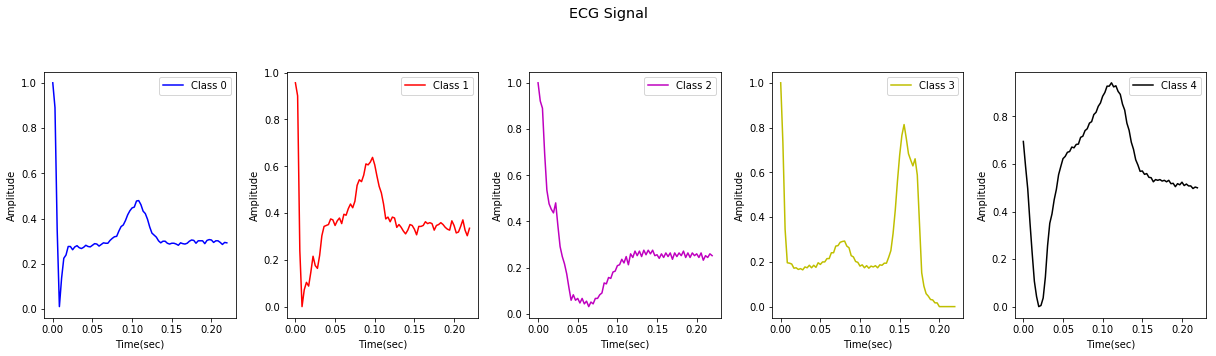

In [4]:
classes=[class1[1],class2[1],class3[1],class4[1],class5[1]]
f, axes = plt.subplots(1,5,figsize=(17,5))
colors=['b','r', 'm', 'y', 'k']
for label,class_ in enumerate(classes):
  ax=axes[label]
  ax.plot(x[:80],X[class_][:80].ravel(),label='Class %i'%(label),color=colors[label])
  ax.legend(loc=1)
  ax.set_xlabel('Time(sec)')
  ax.set_ylabel("Amplitude")
plt.suptitle("ECG Signal",fontsize='x-large')

f.tight_layout()
f.subplots_adjust(top=0.8)
plt.show()

## Baseline CNN

In [0]:
def get_model():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()
file_path = path+"Models/baseline_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

#model.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 183, 16)           96        
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 89, 16)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 89, 16)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 87, 32)            1568      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 85, 32)            3104      
__________

In [0]:
model.load_weights(path+"Models/baseline_cnn_mitbih.h5")

pred_val=model.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)


pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.9925756710451171 
Test accuracy score : 0.9852457518728303 


In this section, simple RNN models are presented trained only on 10 epochs. The main goal is to compare between different RNN cells and finally to disrecard  those which perform worse against the others.

## Simple RNNs

### Classic RNN Cell

In [0]:
#Hidden state size=32
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(SimpleRNN(32))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Simple_RNN_32_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_26 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 32)                1088      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 165       
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 51s - loss: 0.6547 - acc: 0.8272 - val_loss: 0.6314 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to Simple_RNN_32_mitbih.h5
Epoch 2/10
 - 43s - loss: 0.5784 - acc: 0.8314 - val_loss: 0.5063 - val_acc: 0.8512

Epoch 00002: val_acc improved from 0.81989 to 0.85119, saving model to Simple_RNN_32_mitbih.h

In [0]:
model.load_weights(file_path)
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.898364699433583 


In [0]:
#Hidden state size=64
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(SimpleRNN(64))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Simple_RNN_64_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_30 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 325       
Total params: 4,549
Trainable params: 4,549
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 49s - loss: 0.6389 - acc: 0.8264 - val_loss: 0.6142 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to Simple_RNN_64_mitbih.h5
Epoch 2/10
 - 45s - loss: 0.5646 - acc: 0.8305 - val_loss: 0.5196 - val_acc: 0.8397

Epoch 00002: val_acc improved from 0.81989 to 0.83965, saving model to Simple_RNN_64_mitbih.h5
Epoch 3/10
 - 43s - loss: 0.5430 - acc: 0.8482 - val_loss: 0.6030 - val_acc: 0.8199

Epoch 00003: val_acc did not improve from 0.83965
Epoch 4/10
 - 45s - loss: 0.5686 - acc: 0.8286 - val_loss: 0.5678 - val_acc: 0.8199

Epoch 00004: val_acc did not improve from 0.83965
Epoch 5/10
 - 44s - loss: 0.5568 - acc: 0.8282 - val_loss: 0.5801 - val_acc: 0.8199

Epoch 00005: val_acc did not improve from 0.83965

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
 - 44s - loss: 0.5396 - acc: 0.8286 - val_loss: 0.5290 - val_acc: 0.8199

Epoch 00006: val_acc d

In [0]:
model.load_weights(file_path)
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.865019185090444 


### LSTM Cell

In [0]:
#Hidden state size=32
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(LSTM(32))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Simple_LSTM_32_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_27 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 165       
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 130s - loss: 0.7144 - acc: 0.8157 - val_loss: 0.6316 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to Simple_LSTM_32_mitbih.h5
Epoch 2/10
 - 123s - loss: 0.5856 - acc: 0.8296 - val_loss: 0.7138 - val_acc: 0.8199

Epoch 00002: val_acc did not improve from 0.81989
Epoch 3/10
 - 123s - loss: 0.5053 - acc:

In [0]:

model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9238991412388087 


In [0]:
#Hidden state size=64
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(LSTM(64))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Simple_LSTM_64_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_29 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 325       
Total params: 17,221
Trainable params: 17,221
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 130s - loss: 0.6978 - acc: 0.8272 - val_loss: 0.6723 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to Simple_LSTM_64_mitbih.h5
Epoch 2/10
 - 121s - loss: 0.6264 - acc: 0.8286 - val_loss: 0.6289 - val_acc: 0.8199

Epoch 00002: val_acc did not improve from 0.81989
Epoch 3/10
 - 122s - loss: 0.5499 - ac

In [0]:

model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9487940800292344 


### GRU Cell

In [0]:
#Hidden state size=32
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(GRU(32))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "GRU_32_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_32 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
gru_10 (GRU)                 (None, 32)                3264      
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 165       
Total params: 3,429
Trainable params: 3,429
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 103s - loss: 0.7447 - acc: 0.8174 - val_loss: 0.6635 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to GRU_32_mitbih.h5
Epoch 2/10
 - 97s - loss: 0.6066 - acc: 0.8286 - val_loss: 0.5839 - val_acc: 0.8199

Epoch 00002: val_acc did not improve from 0.81989
Epoch 3/10
 - 97s - loss: 0.5576 - acc: 0.8267 - 

In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9113374748766673 


In [0]:
#Hidden state size=64
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(GRU(64))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "GRU_64_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_33 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                12672     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 325       
Total params: 12,997
Trainable params: 12,997
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 102s - loss: 0.7149 - acc: 0.8231 - val_loss: 0.6269 - val_acc: 0.8199

Epoch 00001: val_acc improved from -inf to 0.81989, saving model to GRU_64_mitbih.h5
Epoch 2/10
 - 96s - loss: 0.5274 - acc: 0.8466 - val_loss: 0.4327 - val_acc: 0.8832

Epoch 00002: val_acc improved from 0.81989 to 0.88317, saving model to GRU_64_mitbih.h5
Epoch 3/1

In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9509866617942627 


As it is obvious , the LSTM and GRU cell outperform the simple RNN cell in terms of accuracy. In the next section more complex models are illustrated trained again on only 10 epochs for computional reasons. The RNN cell used is either the LSTM or GRU. After presenting the difference on performance in terms of accuracy among different models, even more complex models will be presented but this time trained on sufficient number of epochs.

## Bidirectional LSTM and GRU


In [0]:
#GRU
#Hidden state size=64
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "GRU_Bid_64_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_34 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               25344     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 645       
Total params: 25,989
Trainable params: 25,989
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 193s - loss: 0.6016 - acc: 0.8490 - val_loss: 0.4213 - val_acc: 0.8754

Epoch 00001: val_acc improved from -inf to 0.87540, saving model to GRU_Bid_64_mitbih.h5
Epoch 2/10
 - 188s - loss: 0.3397 - acc: 0.9059 - val_loss: 0.2948 - val_acc: 0.9174

Epoch 00002: val_acc improved from 0.87540 to 0.91743, saving model to GRU_Bid_64_mitbih.h5


In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9671112735245752 


In [0]:
#GRU
#Hidden state size=64
# add time distributed layer
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(TimeDistributed(Dense(10)))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.2))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Time_Dist_GRU_Bid_64_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_36 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 187, 10)           20        
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               28800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 645       
Total params: 29,465
Trainable params: 29,465
Non-trainable params: 0
_________________________________________________________________
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 210s - loss: 0.5593 - acc: 0.8526 - val_loss: 0.3651 - val_acc: 0.8997

Epo

In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9608076009501187 


In [0]:
#LSTM
#Hidden state size=64
model=Sequential()
model.add(Masking(mask_value=0.,input_shape=(187,1)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = "Bid_Lstm_64.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

model.fit(X, Y, epochs=10,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 34,437
Trainable params: 34,437
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
 - 229s - loss: 0.6412 - acc: 0.8307 - val_loss: 0.4982 - val_acc: 0.8553

Epoch 00001: val_acc improved from -inf to 0.85530, saving model to Bid_Lstm_64.h5
Epoch 2/10
 - 222s - loss: 0.4107 - acc: 0.8852 - val_loss: 0.51

In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9631828978622328 


In this section. more elaborated models are presented, icluding Bidirectional LSTM and GRU, Stacked Bidirectional LSTM and GRU with greater size of hidden states. Also, some of them contains  regularization parameters in order to avoid overfitting since the number of trainable parameters increased considerably. These models are trained on a maximum 100 epochs with earling stopping. On average, 30 epochs are sufficient for training the following models. 




## Final Models
#### All the models including in this section can be loaded from the external file called Models.

### Bidirectional LSTM, Hidden state size=100

In [0]:
#Bidirectional LSTM
#Hidden state size=100
#Dropout in each layer
model1=Sequential()
model1.add(Masking(mask_value=0.,input_shape=(187,1)))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.1))
model1.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = path+'Models/Bid_LSTM__100.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model1.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model1.summary()

#model1.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_10 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               81600     
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1005      
Total params: 82,605
Trainable params: 82,605
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.load_weights(path+'Models/Bid_LSTM__100.h5')

pred_val=model1.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model1.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.9883495145631068 
Test accuracy score : 0.9830074913210305 


### 2 Stacked Bidirectional LSTM, Hidden state size=64

In [0]:
#2 Bidirectional stacked LSTM
#Hidden state size=64
#Dropout in each layer
model2=Sequential()
model2.add(Masking(mask_value=0.,input_shape=(187,1)))
model2.add(Bidirectional(LSTM(64,return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.2))
model2.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = path+"Models/Bid__Lstm__64.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model2.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model2.summary()

#model2.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [0]:
model2.load_weights(path+"Models/Bid__Lstm__64.h5")

pred_val=model2.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model2.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.9856082238720731 
Test accuracy score : 0.981226018636945 


### 2 Stacked Bidirectional LSTM Hidden State Size 100

In [0]:
#2 Bidirectional LSTM
#Hidden state size=100
#Dropout in each layer
model3=Sequential()
model3.add(Masking(mask_value=0.,input_shape=(187,1)))
model3.add(Bidirectional(LSTM(100,return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100)))
model3.add(Dropout(0.2))
model3.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path =path+ 'Models/2_Bid_LSTM_100_100dropout0202.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model3.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model3.summary()

#model3.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 187, 200)          81600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 187, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 323,405
Trainable params: 323,405
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.load_weights(path+'Models/2_Bid_LSTM_100_100dropout0202.h5')

pred_val=model3.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model3.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.9947458595088521 
Test accuracy score : 0.9846976064315732 


### 2 Stacked Bidirectional GRU Hidden State Size 100

In [0]:
#2 Bidirectional GRU
#Hidden state size=100
#Dropout in each layer

model4=Sequential()
model4.add(Masking(mask_value=0.,input_shape=(187,1)))
model4.add(Bidirectional(GRU(100,return_sequences=True)))
model4.add(Dropout(0.2))
model4.add(Bidirectional(GRU(100)))
model4.add(Dropout(0.2))
model4.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = path+'Models/2_Bid_GRU_100_100dropout0202.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model4.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model4.summary()

#model4.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 187, 200)          61200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 187, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               180600    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1005      
Total params: 242,805
Trainable params: 242,805
Non-trainable params: 0
_________________________________________________________________


In [0]:
model4.load_weights(path+'Models/2_Bid_GRU_100_100dropout0202.h5')

pred_val=model4.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model4.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.99565962307253 
Test accuracy score : 0.9873012972775443 


### 2 Stacked Bidirectional GRU Hidden State Size 100,Time distributed layer size 32 between of them

In [0]:
#2 Bidirectional GRU+Time distributed layer
#Hidden state size=100,100
#Dropout in each layer

model6=Sequential()
model6.add(Masking(mask_value=0.,input_shape=(187,1)))
model6.add(Bidirectional(GRU(100,return_sequences=True)))
model6.add(Dropout(0.25))
model6.add(TimeDistributed(Dense(32)))
model6.add(Bidirectional(GRU(100)))
model6.add(Dropout(0.25))
model6.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = path+'Models/2_Bid_GRU_100_Time_distributed_layer_64_100_dropout02525.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model6.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model6.summary()

#model6.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [0]:
model6.load_weights(path+'Models/2_Bid_GRU_100_Time_distributed_layer_64_100_dropout02525.h5')

pred_val=model6.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model6.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.993032552826956 
Test accuracy score : 0.9866161154759729 


### 3 Stacked Bidirectional GRU Hidden State Size 100,100,64

In [0]:
#3 Bidirectional GRU
#Hidden state size=100,100,64
#Dropout in each layer
model5=Sequential()
model5.add(Masking(mask_value=0.,input_shape=(187,1)))
model5.add(Bidirectional(GRU(100,return_sequences=True)))
model5.add(Dropout(0.3))
model5.add(Bidirectional(GRU(100,return_sequences=True)))
model5.add(Dropout(0.3))
model5.add(Bidirectional(GRU(64)))
model5.add(Dropout(0.1))
model5.add(Dense(5,activation=activations.softmax))

opt = optimizers.Adam(0.001)

file_path = path+'Models/3_Bid_GRU_100_100_64_dropout030301.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

model5.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model5.summary()

#model5.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 187, 200)          61200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 187, 200)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 187, 200)          180600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 187, 200)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               101760    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
__________

In [0]:
model5.load_weights(path+'Models/3_Bid_GRU_100_100_64_dropout030301.h5')

pred_val=model5.predict(X[-int(0.1*len(X)):])
pred_val = np.argmax(pred_val, axis=-1)

acc = accuracy_score(Y[-int(0.1*len(X)):], pred_val)

print("Validation accuracy score : %s "% acc)

pred_test = model5.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Validation accuracy score : 0.9947458595088521 
Test accuracy score : 0.9867988306230586 


## Combine Models

### Average models

In [0]:
pred_test3 = model3.predict(X_test)
pred_test4 = model4.predict(X_test)
pred_test5 = model5.predict(X_test)
pred_test6 = model6.predict(X_test)

In [0]:
#keeping only the 4 best models out of 6
preds=np.concatenate((pred_test3,pred_test4,pred_test5,pred_test6),axis=1).reshape((X_test.shape[0],-1,5))
aver_pred=np.mean(preds,axis=1)
predictions=np.argmax(aver_pred,axis=1)

In [0]:
acc = accuracy_score(Y_test, predictions)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9884889457336014 


### Logistic Regression Model with classifiers as input 

In [0]:
valid=X[-int(0.1*len(X)):]
pred_val3 = model3.predict(valid)
pred_val4 = model4.predict(valid)
pred_val5 = model5.predict(valid)
pred_val6 = model6.predict(valid)

In [0]:
#keeping only the 4 best models out of 6 and training on the validation set
inputs=np.concatenate((pred_val3,pred_val4,pred_val5,pred_val6),axis=1)

In [0]:
lr=LogisticRegression(C=100)
lr.fit(inputs,Y[-int(0.1*len(Y)):])

In [0]:
lr_predictions=lr.predict(preds.reshape((-1,inputs.shape[1])))

In [0]:
acc = accuracy_score(Y_test,lr_predictions)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9887630184542299 


## Results

In [0]:
Classifiers=["Baseline CNN","Bid. LSTM Hidden State Size=100","2 Stacked Bid. LSTM Hidden State Size=64","2 Stacked Bid. LSTM Hidden state size=100"\
           ,"2 Stacked Bid. GRU Hidden state size=100","2 Stacked Bid. GRU HSS=100 plus Time Distr. Layer",\
            "3 Stacked Bid. GRU Hidden state size=100,100,64"]
Validation_Accuracy=[0.994,0.988,0.986,0.995,0.996,0.993,0.995]
Test_Accuracy=[0.9852,0.983,0.9812,0.9847,0.9873,0.9866,0.9868]
Ensembles=['Average Models','Fit a Logistic Regression Model']
Val_acc=['-','-']
Test_acc=[0.9885,0.9888]

arrays=[7*['Classifiers']+2*["Ensembles of Best 4 Classifiers"],Classifiers+Ensembles]
index = pd.MultiIndex.from_tuples(list(zip(*arrays)))
Results=pd.DataFrame(index=index)
Results['Validation Accuracy']=Validation_Accuracy+Val_acc
Results['Test Accuracy']=Test_Accuracy+Test_acc
Results

Validation Accuracy  \
Classifiers                     Baseline CNN                                                    0.994   
                                Bid. LSTM Hidden State Size=100                                 0.988   
                                2 Stacked Bid. LSTM Hidden State Size=64                        0.986   
                                2 Stacked Bid. LSTM Hidden state size=100                       0.995   
                                2 Stacked Bid. GRU Hidden state size=100                        0.996   
                                2 Stacked Bid. GRU HSS=100 plus Time Distr. Layer               0.993   
                                3 Stacked Bid. GRU Hidden state size=100,100,64                 0.995   
Ensembles of Best 4 Classifiers Average Models                                                      -   
                                Fit a Logistic Regression Model                                     -   

                                                                                   Test Accuracy  
Classifiers                     Baseline CNN                                              0.9852  
                                Bid. LSTM Hidden State Size=100                           0.9830  
                                2 Stacked Bid. LSTM Hidden State Size=64                  0.9812  
                                2 Stacked Bid. LSTM Hidden state size=100                 0.9847  
                                2 Stacked Bid. GRU Hidden state size=100                  0.9873  
                                2 Stacked Bid. GRU HSS=100 plus Time Distr. Layer         0.9866  
                                3 Stacked Bid. GRU Hidden state size=100,100,64           0.9868  
Ensembles of Best 4 Classifiers Average Models                                            0.9885  
                                Fit a Logistic Regression Model                           0.9888